In [1]:
import numpy as np
from loadmodules import *
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.mixture import GaussianMixture

from numba import njit, config, get_num_threads
config.THREADING_LAYER = 'omp'
print("Numba threads:", get_num_threads())

%matplotlib inline

Numba threads: 16


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
def mask_equal_to_previous(arr):
    mask = np.ones(len(arr), dtype=bool)
    mask[1:] = arr[1:] != arr[:-1]
    return mask

def B(x):
    return sp.special.erf(x) * 2.*x*np.exp(-x**2)/np.sqrt(np.pi)

@njit(parallel=True)
def velocity_dispersion(radius, parts_radius, starparts, s_data_age, s_data_vel, s_data_type):
    # Select particles within the given radius
    within_radius = parts_radius[starparts][s_data_age > 0.] < radius
    if within_radius.sum() >= 48:
        velocities = np.sqrt(np.sum(s_data_vel[starparts][s_data_age > 0.][within_radius]**2, axis=1))
    # if not enough stars, use dark matter particles
    else:
        mask_dm = (s_data_type != 4) * (s_data_type != 0)
        within_radius = parts_radius[mask_dm] < radius
        velocities = np.sqrt(np.sum(s_data_vel[mask_dm][within_radius]**2, axis=1))

    # Calculate the velocity dispersion
    if velocities.size == 0:
        return 0.0
    # Avoid division by zero
    else:
        return np.std(velocities)

In [8]:
def get_mass_functions(simulation, snapshot=127, subdir='/output/', age_young = 1., age_intermediate=6., age_old=10., inner_radius=0., outer_radius=None,\
                       low_mass_cut=None, high_mass_cut=None, apply_df=False, decomposition=None, plot_agedistribution=False, plot_dynamicfriction=False, plot_decomposition=False):
    sf = load_subfind(snapshot, dir=simulation+subdir, hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
    s = gadget_readsnap(snapshot, snappath=simulation+subdir, subfind=sf, hdf5=True, loadonlyhalo=0)
    s.calc_sf_indizes( sf )
    galrad = 0.5 * sf.data['frc2'][0]
    s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )
    if outer_radius is None:
        outer_radius = 1e3*galrad

    print('Redshift of the simulation: {:2.2f}'.format(s.redshift))

    Gcosmo = 43.
    starparts = (s.data['age']>0.) * (s.r()[s.data['type']==4] < galrad)
    
    kinetic_energy = np.sum(s.data['vel']**2, axis=1)

    orbital_energy = s.data['pot'] + 0.5 * kinetic_energy
    orbital_energy /= 1e5
    
    Jtot = np.sqrt((np.cross( s.data['pos'], (s.data['vel'] ))**2).sum(axis=1))
    Lz = np.cross( s.data['pos'], (s.data['vel'] ) )[:,0]
    Lz *= np.sign(np.nanmedian(Lz))

    parts_radius = s.r()
    isort_parts = np.argsort(parts_radius)
    revert_sort = np.argsort(isort_parts)
    cummass = np.cumsum(s.data['mass'][isort_parts])
    Vc_parts = np.sqrt(Gcosmo*cummass[revert_sort]/parts_radius)

    # Energy of circular orbits at increasing radii
    Ecirc = 0.5*Vc_parts[isort_parts]**2 + s.data['pot'][isort_parts]
    Ecirc /= 1e5
    e_max = np.nanmax(Ecirc[~np.isinf(Ecirc)])
    orbital_energy -= e_max
    Ecirc -= e_max

    mask = mask_equal_to_previous(parts_radius[isort_parts][~np.isinf(Ecirc)])

    r_test = np.logspace(-5, np.log10(parts_radius.max()), 500)
    Ecirc_f = sp.interpolate.PchipInterpolator(parts_radius[isort_parts][~np.isinf(Ecirc)][mask], Ecirc[~np.isinf(Ecirc)][mask])
    Vc_f = sp.interpolate.PchipInterpolator(parts_radius[isort_parts][~np.isinf(Ecirc)][mask], Vc_parts[isort_parts][~np.isinf(Ecirc)][mask])
    Mr_f = sp.interpolate.PchipInterpolator(parts_radius[isort_parts][~np.isinf(Ecirc)][mask], cummass[~np.isinf(Ecirc)][mask])
    
    mask_clusters_initial = ((s.data['incl'][starparts] > 0 ) * (1e3*parts_radius[s.data['type']==4][starparts] > inner_radius) *
                            (1e3*parts_radius[s.data['type']==4][starparts] <= outer_radius)) # * (np.abs(1e3*s.data['pos'][starparts,0])>0.2))
    
    idx = np.argmin(np.abs(orbital_energy[s.data['type']==4][starparts][:,np.newaxis] - Ecirc_f(r_test)), axis=1)
    rc = r_test[idx]
    vc = Vc_f(rc)
    Lzmax = rc*vc
    circ_param = Lz[s.data['type']==4][starparts]/Lzmax
    # circ_param[np.abs(circ_param) > 1.5] = 1.5 * np.sign(circ_param[np.abs(circ_param) > 1.5])

    if decomposition is None:
        mask_decomposition = np.ones_like(circ_param[mask_clusters_initial], dtype=bool)
    else:
        # Build feature array: [ε, Energy]
        X = np.vstack((circ_param, orbital_energy[s.data['type']==4][starparts])).T

        # Fit GMM
        gmm = GaussianMixture(n_components=2, means_init=[[0.0,np.median(orbital_energy[s.data['type']==4][starparts])],
                                                          [1.0,np.median(orbital_energy[s.data['type']==4][starparts])]],
                                                          random_state=42, covariance_type='full')
        gmm.fit(X)

        # Predict cluster memberships
        decomposition_label = gmm.predict(X)
        mean_values = [np.median(circ_param[decomposition_label==i]) for i in range(gmm.n_components)]
        gc_label = np.argmin(mean_values)
        print('GC decomposition label:', gc_label)
        
        if decomposition == 'Spheroid':
            mask_decomposition = decomposition_label[mask_clusters_initial] == gc_label
        elif decomposition == 'Disc':
            mask_decomposition = decomposition_label[mask_clusters_initial] != gc_label

        if plot_decomposition:
            label_color = plt.cm.viridis(np.linspace(0, 1, 2))
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            ax[0].scatter(circ_param, orbital_energy[s.data['type']==4][starparts],
                        c=decomposition_label, s=1, cmap='viridis', alpha=0.5, edgecolors='face')
            ax[0].set(xlabel='Circularity ε', ylabel='Energy', xlim=(-2,2))

            ax[1].hist(circ_param, histtype='step', bins=20, range=[-1.5,1.5], label='Stars with SCs')
            for i in range(gmm.n_components):
                ax[1].hist(circ_param[(decomposition_label==i)], histtype='step', edgecolor=label_color[i], bins=20, range=[-1.5,1.5], label=f'Component {i}')
            ax[1].get_yaxis().set_ticks([])
            ax[1].legend()
            ax[1].set_xlabel('Circularity ε')
            plt.show()

        # if decomposition=='Spheroid':
        #     mask_decomposition = circ_param[mask_clusters_initial] < 0.7
        # elif decomposition=='Disc':
        #     mask_decomposition = circ_param[mask_clusters_initial] >= 0.7
    
    cluster_masses = s.data['mclt'][starparts][mask_clusters_initial][mask_decomposition].flatten()
    init_cluster_masses = s.data['imcl'][starparts][mask_clusters_initial][mask_decomposition].flatten()
    
    not_empty_clusters = (init_cluster_masses>0.)

    cluster_masses = cluster_masses[not_empty_clusters]
    init_cluster_masses = init_cluster_masses[not_empty_clusters]

    print('Maximum initial number of clusters per star {:d}'.format(s.data['incl'].max()))
    print('Maximum initial mass {:2.2e} Msun'.format(1e10*init_cluster_masses.max()))
    print('Maximum present-day mass {:2.2e} Msun'.format(1e10*cluster_masses.max()))

    clusters_formtime = np.repeat(s.data['age'][starparts][mask_clusters_initial][mask_decomposition], s.data['incl'][starparts][mask_clusters_initial][mask_decomposition])
    clusters_age = s.cosmology_get_lookback_time_from_a(clusters_formtime, is_flat=True) - s.cosmology_get_lookback_time_from_a(s.time, is_flat=True)

    mask_problematic = s.data['imfc'][starparts][mask_clusters_initial][mask_decomposition]>1.
    print('Problematic stars with clusters {:4d}'.format(mask_problematic.sum()))
    print('That`s {:.3f} per cent of stars with clusters'.format(mask_problematic.sum()/len(s.data['imfc'][starparts][mask_clusters_initial][mask_decomposition]) * 100))

    if low_mass_cut is None:
        low_mass_cut = 1e2
    if high_mass_cut is None:
        high_mass_cut = 1e8
    
    not_empty_clusters = (cluster_masses>0.)
    init_mass_cut = (1e10*init_cluster_masses[not_empty_clusters]>low_mass_cut) * (1e10*init_cluster_masses[not_empty_clusters]<high_mass_cut)
    
    if plot_agedistribution:
        plt.hist(clusters_age[not_empty_clusters][init_mass_cut], bins=20, histtype='step', density=True)
        plt.xlabel('Cluster`s age [Gyr]')
        plt.ylabel('Age Distribution')
        plt.title(simulation)
        plt.show()
    
    if apply_df:
        rc_clus = np.repeat(rc[mask_clusters_initial][mask_decomposition], s.data['nclt'][starparts][mask_clusters_initial][mask_decomposition])[init_mass_cut]
        M_rc_clus = Mr_f(rc[mask_clusters_initial][mask_decomposition])
        M_rc_clus = np.repeat(M_rc_clus, s.data['nclt'][starparts][mask_clusters_initial][mask_decomposition])[init_mass_cut]
        vc_rc_clus = np.repeat(vc[mask_clusters_initial][mask_decomposition], s.data['nclt'][starparts][mask_clusters_initial][mask_decomposition])[init_mass_cut]
        sigma_rc_clus = np.array([velocity_dispersion(r, s.r(), starparts, s.data['age'], s.data['vel'], s.data['type']) for r in 
                                rc[mask_clusters_initial][mask_decomposition][s.data['nclt'][starparts][mask_clusters_initial][mask_decomposition]>0]])
        sigma_rc_clus = np.repeat(sigma_rc_clus,\
                                  s.data['nclt'][starparts][mask_clusters_initial][mask_decomposition][s.data['nclt'][starparts][mask_clusters_initial][mask_decomposition]>0])[init_mass_cut]

        feps = np.repeat((Jtot[s.data['type']==4][starparts][mask_clusters_initial][mask_decomposition]/Lzmax[mask_clusters_initial][mask_decomposition])**0.78,\
                          s.data['nclt'][starparts][mask_clusters_initial][mask_decomposition])[init_mass_cut]
        coulumblog = np.log(1. + M_rc_clus/cluster_masses[not_empty_clusters][init_mass_cut])
        
        tdf = feps/(2*B(vc_rc_clus/(np.sqrt(2.)*sigma_rc_clus)))*np.sqrt(2.)*sigma_rc_clus*rc_clus**2./(Gcosmo*cluster_masses[not_empty_clusters][init_mass_cut]*coulumblog)
        tdf *= s.UnitLength_in_cm/s.UnitVelocity_in_cm_per_s / (1e9*365.25*24*3600)

        mask_disrupted = (tdf < clusters_age[not_empty_clusters][init_mass_cut])
        print('Clusters disrupted by dynamical friction {:4d}'.format(mask_disrupted.sum()))
        if(plot_dynamicfriction):
            plt.hist(tdf, bins=np.logspace(-1, 3, 20), histtype='step')
            plt.xscale('log')
            plt.xlabel('Dynamical Friction Timescale [Gyr]')
            plt.ylabel('Number of clusters')
            plt.title(simulation)
            plt.show()
    else:
        mask_disrupted = np.zeros_like(cluster_masses[not_empty_clusters][init_mass_cut], dtype=bool)
        if(plot_dynamicfriction):
            print('Bad usage, no DF applied')

    young_mask = (clusters_age[not_empty_clusters][init_mass_cut][~mask_disrupted]<age_young)
    intemediate_mask = (clusters_age[not_empty_clusters][init_mass_cut][~mask_disrupted]>age_intermediate)
    old_mask = (clusters_age[not_empty_clusters][init_mass_cut][~mask_disrupted]>age_old)

    nbins = 25
    min_gcmf = 1e2 # in solar masses
    min_icmf = 5e3 # in solar masses
    max_gcmf = 1e8 # in solar masses
    marray_gcmf = np.linspace(np.log10(min_gcmf), np.log10(max_gcmf), nbins + 1)
    marray_icmf = np.linspace(np.log10(min_icmf), np.log10(max_gcmf), nbins + 1)
    width_gcmf = np.diff(marray_gcmf)
    width_icmf = np.diff(marray_icmf)

    init_mass_mask = (1e10*init_cluster_masses>low_mass_cut) * (1e10*init_cluster_masses<high_mass_cut)
    N,_ = np.histogram(np.log10(1e10*init_cluster_masses[init_mass_mask]), bins=marray_icmf)
    initial_population = N/width_icmf
    N,_ = np.histogram(np.log10(1e10*cluster_masses[not_empty_clusters][init_mass_cut][~mask_disrupted]), bins=marray_gcmf)
    full_population = N/width_gcmf
    N,_ = np.histogram(np.log10(1e10*cluster_masses[not_empty_clusters][init_mass_cut][~mask_disrupted][young_mask]), bins=marray_gcmf)
    young_population = N/width_gcmf
    N,_ = np.histogram(np.log10(1e10*cluster_masses[not_empty_clusters][init_mass_cut][~mask_disrupted][intemediate_mask]), bins=marray_gcmf)
    intermediate_population = N/width_gcmf
    N,_ = np.histogram(np.log10(1e10*cluster_masses[not_empty_clusters][init_mass_cut][~mask_disrupted][old_mask]), bins=marray_gcmf)
    old_population = N/width_gcmf

    return [initial_population, full_population, young_population, intermediate_population, old_population]

In [4]:
nbins = 25
min_gcmf = 1e2 # in solar masses
min_icmf = 5e3 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.linspace(np.log10(min_gcmf), np.log10(max_gcmf), nbins + 1)
marray_icmf = np.linspace(np.log10(min_icmf), np.log10(max_gcmf), nbins + 1)
width = np.diff(marray_gcmf)
marray_plot = 0.5 * (marray_gcmf[:-1] + marray_gcmf[1:])
imarray_plot = 0.5 * (marray_icmf[:-1] + marray_icmf[1:])

In [5]:
m31_masses = np.genfromtxt('catalogues_compare/Caldwell_dataonly.txt', usecols=11, delimiter=',')
m31_rgc = np.genfromtxt('catalogues_compare/Caldwell_dataonly.txt', usecols=12, delimiter=',')
N,_ = np.histogram(m31_masses, bins=marray_gcmf)
m31_mass_function = N/width
N,_ = np.histogram(m31_masses[m31_rgc <= 3.], bins=marray_gcmf)
m31_inner_mass_function = N/width
N,_ = np.histogram(m31_masses[(m31_rgc > 3.) * (m31_rgc <= 9.)], bins=marray_gcmf)
m31_intermediate_mass_function = N/width
N,_ = np.histogram(m31_masses[(m31_rgc > 9.)], bins=marray_gcmf)
m31_outer_mass_function = N/width

mw_catalogue = np.genfromtxt('catalogues_compare/Harris_onlyphotometry.txt', usecols=(0,6,12), delimiter=',', skip_header=1)
mw_masses = np.log10(1.7 * 10**(0.4*(4.83 - mw_catalogue[:,1])))
mw_rgc = mw_catalogue[:,2]
N,_ = np.histogram(mw_masses, bins=marray_gcmf)
mw_mass_function = N/width
N,_ = np.histogram(mw_masses[mw_rgc <= 3.], bins=marray_gcmf)
mw_inner_mass_function = N/width
N,_ = np.histogram(mw_masses[(mw_rgc > 3.) * (mw_rgc <= 9.)], bins=marray_gcmf)
mw_intermediate_mass_function = N/width
N,_ = np.histogram(mw_masses[(mw_rgc > 9.)], bins=marray_gcmf)
mw_outer_mass_function = N/width

In [6]:
# emosaics_gcmf = np.loadtxt('catalogues_compare/emosaics.csv', delimiter=',')
# emp_10gyr = np.loadtxt('catalogues_compare/EMP_initsize_wevo.csv', delimiter=',')
# emp_6gyr = np.loadtxt('catalogues_compare/EMP_6gyr.csv', delimiter=',')
# gbf_allgcmf = np.loadtxt('catalogues_compare/GBFire_all.csv', delimiter=',')
# gbf_oldgcmf = np.loadtxt('catalogues_compare/GBFire_old.csv', delimiter=',')
# twophase_gcmf = np.loadtxt('catalogues_compare/TwoPhase_GCs.csv', delimiter=',')

In [7]:
dir = './'
simulation_list = [directory for directory in os.listdir(dir) if 'lvl4_d8ad_dr' in directory]
print(simulation_list)
# simulation_list = [simulation_list[0], simulation_list[1], simulation_list[2], simulation_list[4], simulation_list[5], simulation_list[6]] 
# print(simulation_list)

['Au6_lvl4_d8ad_drh0', 'Au18_lvl4_d8ad_drh0']


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.022342459857463838
Found 2229646 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
GC decomposition label: 0


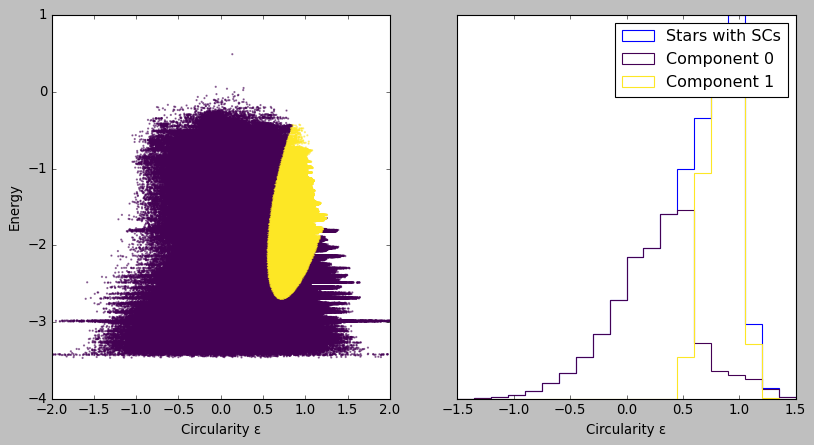

Maximum initial number of clusters per star 7
Maximum initial mass 7.58e+07 Msun
Maximum present-day mass 4.22e+07 Msun
Problematic stars with clusters 13611
That`s 9.420 per cent of stars with clusters


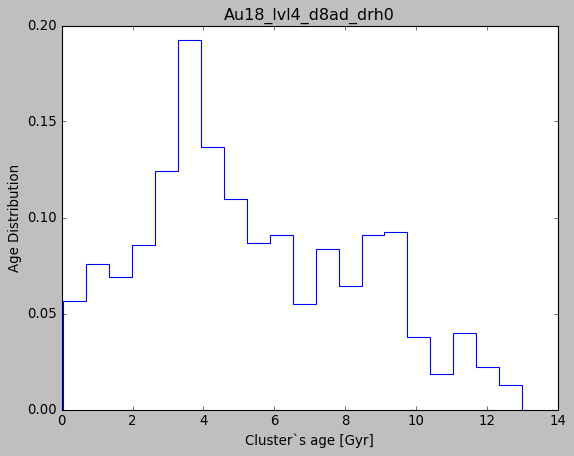

In [9]:
base_init, base_full, base_young, base_intermediate, base_old = get_mass_functions(simulation_list[1], snapshot=127, subdir='/output/',  age_young=1.,\
                                                                                   age_intermediate=6., age_old=10., apply_df=False,\
                                                                                   decomposition='Spheroid', plot_agedistribution=True, plot_decomposition=True, low_mass_cut=1e5)

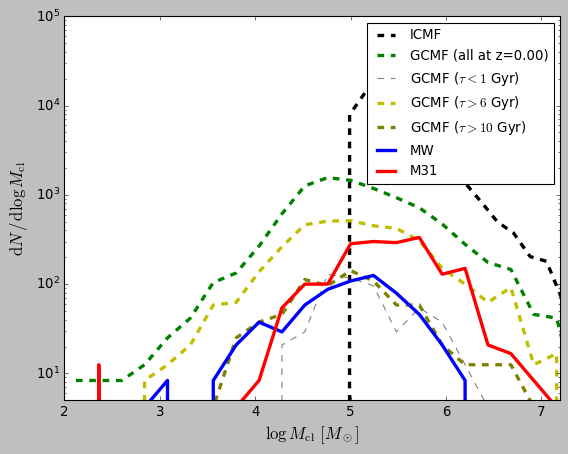

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(imarray_plot, base_init,c='k', linestyle='dashed', linewidth = 3, label='ICMF')
ax.plot(marray_plot, base_full,c='g', linestyle='dashed', linewidth = 3, label='GCMF (all at z=0.00)')
ax.plot(marray_plot, base_young,c='gray', linestyle='dashed', linewidth = 1, label=r'GCMF ($\tau < 1$ Gyr)')
ax.plot(marray_plot, base_intermediate,c='y', linestyle='dashed', linewidth = 3, label=r'GCMF ($\tau > 6$ Gyr)')
ax.plot(marray_plot, base_old,c='olive', linestyle='dashed', linewidth = 3, label=r'GCMF ($\tau > 10$ Gyr)')
ax.plot(marray_plot, mw_mass_function,linewidth=3, c='b', label='MW')
ax.plot(marray_plot, m31_mass_function,linewidth=3, c='r', label='M31')
ax.set_xlim(2,7.2)
ax.set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=15)
ax.set(ylim=(5e0,1e5), yscale= 'log')
ax.set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=15)
ax.tick_params(labelsize=12)
ax.legend(loc='upper right', fontsize=12)
# ax.set_title(r'Au6_lvl4_K12_fiducial', fontsize=15)
# plt.savefig('plots/Au6_lvl4_1e4.pdf')

In [20]:
initial_population =[]
full_population = []
young_population = []
intermediate_population = []
old_population = []
labels = []

for i, sim in enumerate(simulation_list):
    labels.append(sim)
    # if i == 0:
    init, full, young, intermediate, old = get_mass_functions(sim, snapshot=127, apply_df=False, subdir='/output/', age_intermediate=6., age_old=8., exclude_disk=True,
                                                              low_mass_cut=1e5)
    # else:
    #     init, full, young, intermediate, old = get_mass_functions(sim, snapshot=127, apply_df=False, subdir='/output/', age_intermediate=6., age_old=8., exclude_disk=True)
    initial_population.append(init)
    full_population.append(full)
    young_population.append(young)
    intermediate_population.append(intermediate)
    old_population.append(old)

/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.02146396636962891
Found 1406988 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 5
Maximum initial mass 8.92e+07 Msun
Maximum present-day mass 2.15e+07 Msun
Problematic stars with clusters 2506
That`s 9.692 per cent of stars with clusters


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.02146396636962891
Found 1406988 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 5
Maximum initial mass 8.92e+07 Msun
Maximum present-day mass 2.16e+07 Msun
Problematic stars with clusters 2506
That`s 9.692 per cent of stars with clusters


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.021417133510112762
Found 1609776 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 6
Maximum initial mass 4.31e+07 Msun
Maximum present-day mass 2.07e+07 Msun
Problematic stars with clusters 9411
That`s 8.988 per cent of stars with clusters


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.02136577367782593
Found 1533677 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 5
Maximum initial mass 7.75e+07 Msun
Maximum present-day mass 6.14e+06 Msun
Problematic stars with clusters 1275
That`s 9.158 per cent of stars with clusters


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.02146396636962891
Found 1406988 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 5
Maximum initial mass 8.92e+07 Msun
Maximum present-day mass 2.15e+07 Msun
Problematic stars with clusters 2506
That`s 9.692 per cent of stars with clusters


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.02146396636962891
Found 1406988 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 5
Maximum initial mass 8.92e+07 Msun
Maximum present-day mass 2.14e+07 Msun
Problematic stars with clusters 2506
That`s 9.692 per cent of stars with clusters


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.021452526748180392
Found 1415689 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 6
Maximum initial mass 3.40e+07 Msun
Maximum present-day mass 1.10e+07 Msun
Problematic stars with clusters 3103
That`s 10.223 per cent of stars with clusters


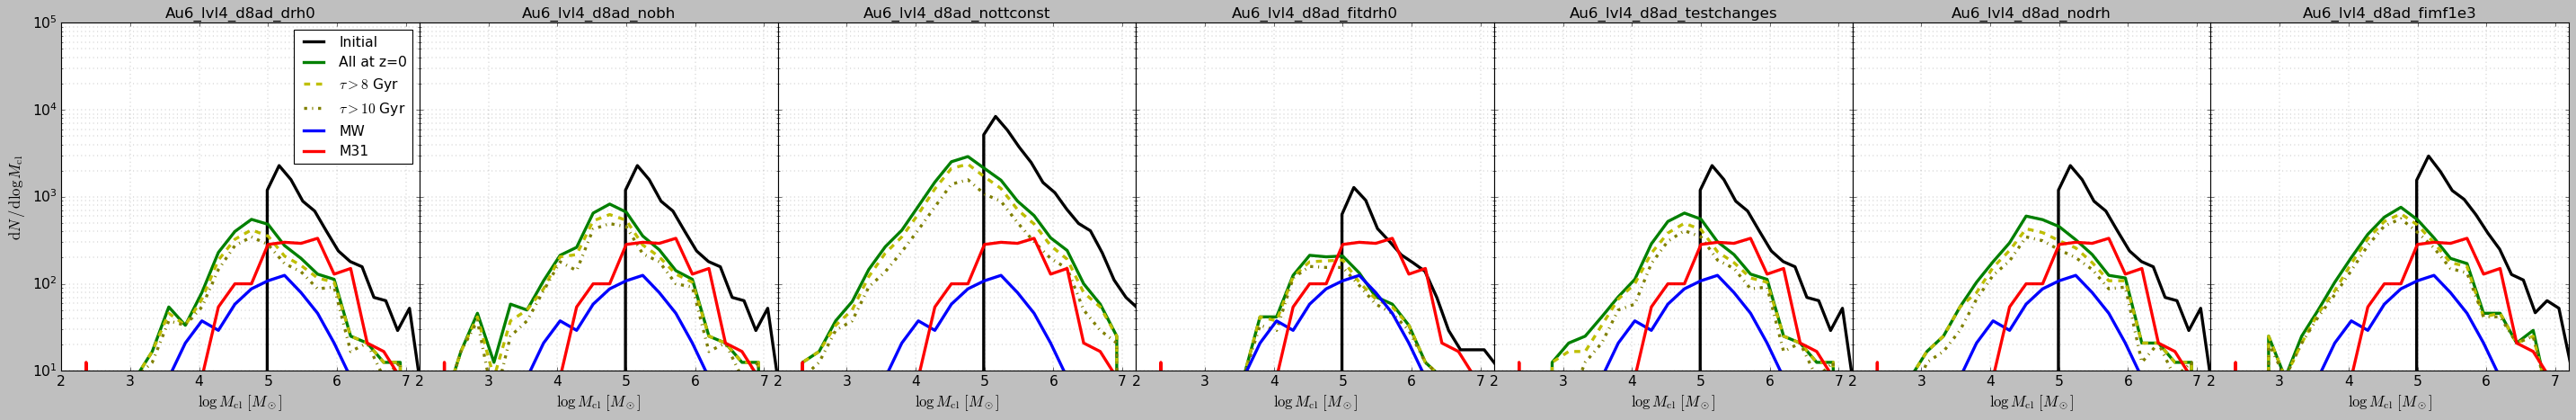

In [21]:
nsubs = 7
fig, ax = plt.subplots(1, nsubs, sharey=True, figsize=(nsubs*5 + 1,6))

for i,mf in enumerate(initial_population):
  # if((i+1)%2 == 0):
  #   ax[i].plot(imarray_plot, initial_population[i-1], c='grey', linewidth=0.5)
  ax[i].plot(imarray_plot, mf, c='k', linewidth=3, label='Initial')
  
for i,mf in enumerate(full_population):
  # if((i+1)%2 == 0):
  #   ax[i].plot(marray_plot, full_population[i-1], c='grey', linewidth=0.5)
  ax[i].plot(marray_plot, mf, c='g', linewidth=3, label='All at z=0')

for i,mf in enumerate(intermediate_population):
  # if((i+1)%2 == 0):
  #   ax[i].plot(marray_plot, intermediate_population[i-1], c='grey', linewidth=0.5)
  ax[i].plot(marray_plot, mf, c='y', linewidth=3, linestyle='--', label=r'$\tau > 8$ Gyr')
  
for i,mf in enumerate(old_population):
  # if((i+1)%2 == 0):
  #   ax[i].plot(marray_plot, old_population[i-1], c='grey', linewidth=0.5)
  ax[i].plot(marray_plot, mf, c='olive', linewidth=3, linestyle='-.', label=r'$\tau > 10$ Gyr')

for i in range(len(ax)):
  ax[i].plot(marray_plot, mw_mass_function, linewidth=3, c='b', label='MW')
  ax[i].plot(marray_plot, m31_mass_function, linewidth=3, c='r', label='M31')
  ax[i].set_xlim(2,7.2)
  ax[i].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=15)
  ax[i].tick_params(labelsize=14)
  ax[i].set_title(labels[i], fontsize=15)
  ax[i].grid(True, which='both', linewidth=0.2)

ax[0].set(ylim=(1e1,1e5), yscale= 'log')
ax[0].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=15)
ax[0].legend(loc='upper right', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(wspace=0)
# plt.savefig('plots/disk_fimf_tview_gcmf_compare.pdf')

/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.02146396636962891
Found 1406988 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
GC decomposition label: 0


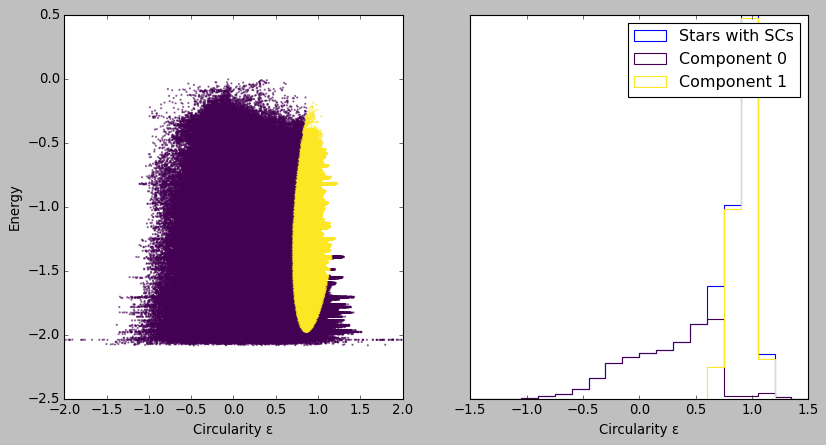

Maximum initial number of clusters per star 5
Maximum initial mass 8.92e+07 Msun
Maximum present-day mass 2.15e+07 Msun
Problematic stars with clusters 3948
That`s 9.701 per cent of stars with clusters


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.02146396636962891
Found 1406988 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
GC decomposition label: 0


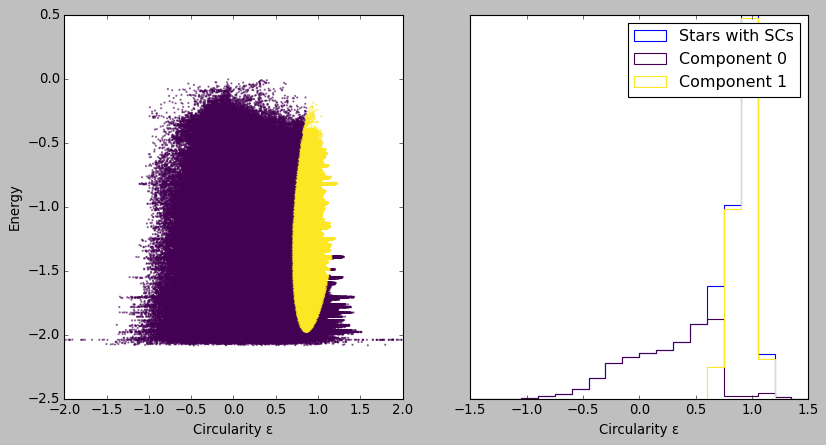

Maximum initial number of clusters per star 5
Maximum initial mass 8.92e+07 Msun
Maximum present-day mass 2.15e+07 Msun
Problematic stars with clusters 3948
That`s 9.701 per cent of stars with clusters


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.02146396636962891
Found 1406988 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
GC decomposition label: 0


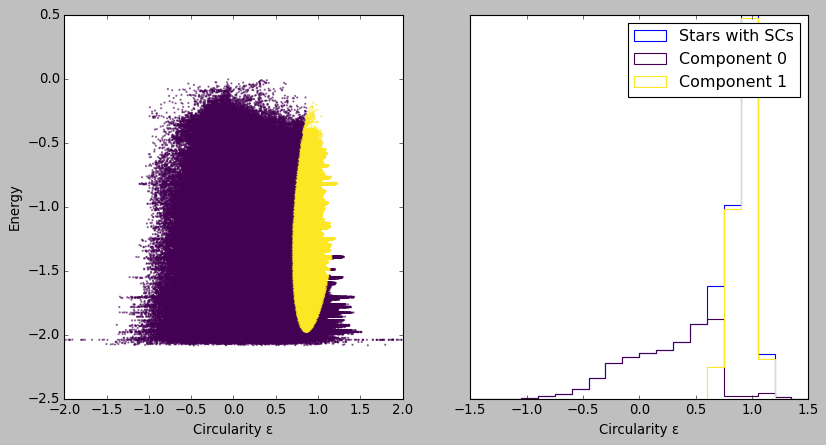

Maximum initial number of clusters per star 5
Maximum initial mass 8.92e+07 Msun
Maximum present-day mass 2.15e+07 Msun
Problematic stars with clusters 3948
That`s 9.701 per cent of stars with clusters


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.02146396636962891
Found 1406988 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
GC decomposition label: 0


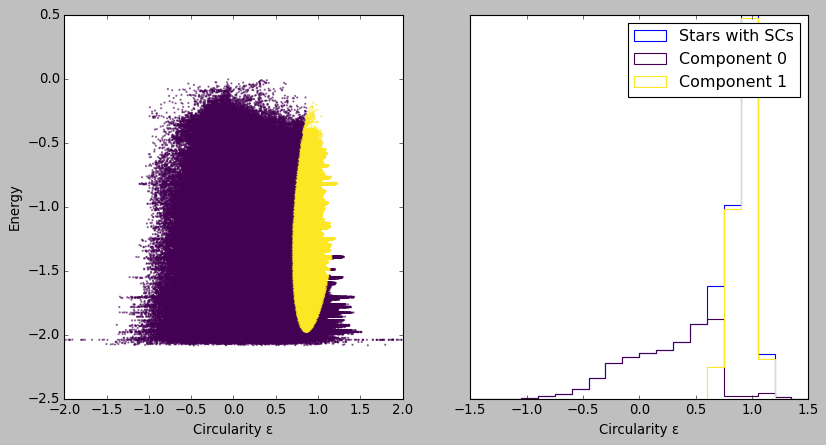

Maximum initial number of clusters per star 5
Maximum initial mass 8.92e+07 Msun
Maximum present-day mass 2.15e+07 Msun
Problematic stars with clusters 3948
That`s 9.701 per cent of stars with clusters


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.022342459857463838
Found 2229646 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
GC decomposition label: 0


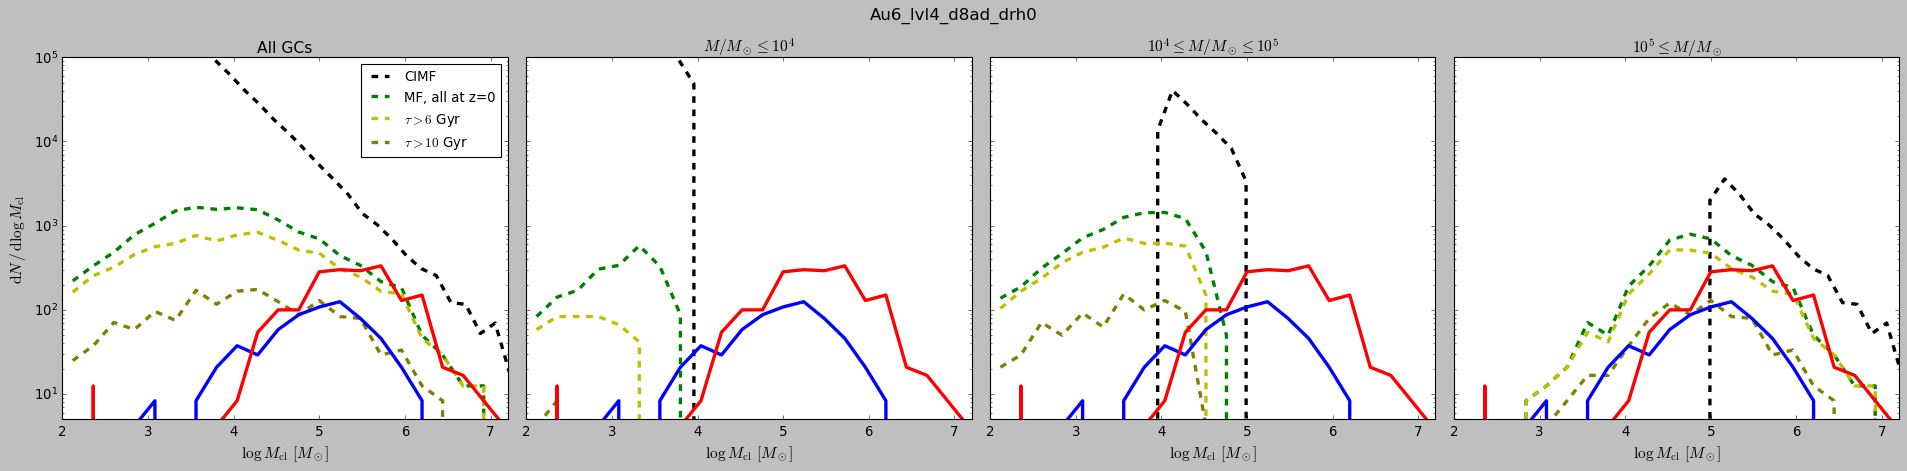

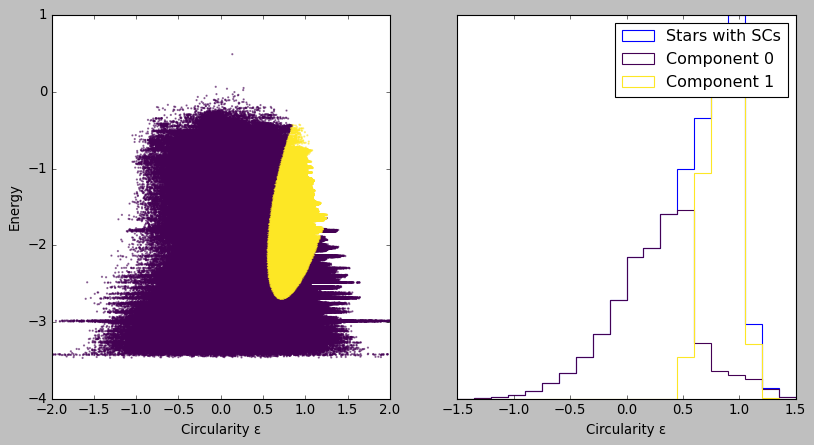

Maximum initial number of clusters per star 7
Maximum initial mass 7.58e+07 Msun
Maximum present-day mass 4.22e+07 Msun
Problematic stars with clusters 13611
That`s 9.420 per cent of stars with clusters


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.022342459857463838
Found 2229646 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
GC decomposition label: 0


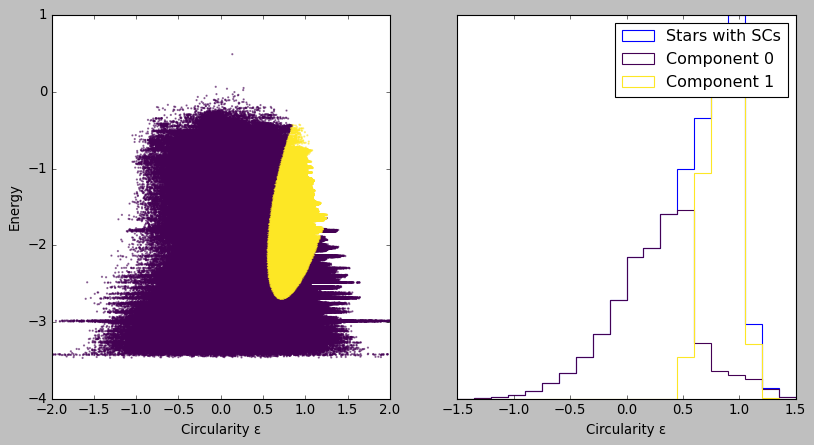

Maximum initial number of clusters per star 7
Maximum initial mass 7.58e+07 Msun
Maximum present-day mass 4.22e+07 Msun
Problematic stars with clusters 13611
That`s 9.420 per cent of stars with clusters


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.022342459857463838
Found 2229646 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
GC decomposition label: 0


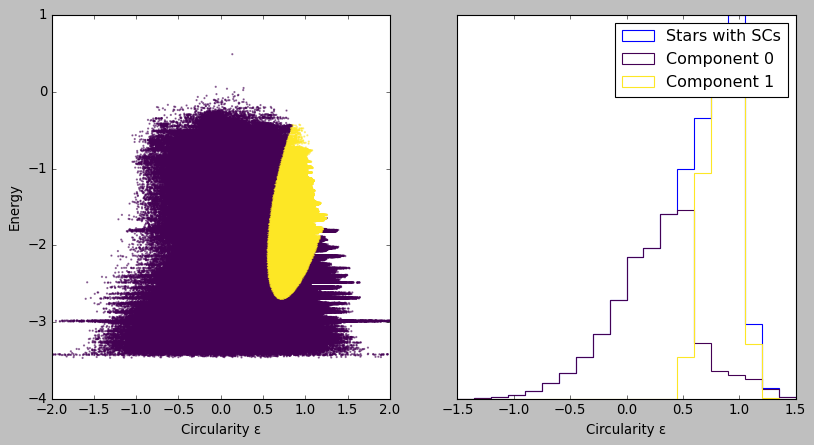

Maximum initial number of clusters per star 7
Maximum initial mass 7.58e+07 Msun
Maximum present-day mass 4.22e+07 Msun
Problematic stars with clusters 13611
That`s 9.420 per cent of stars with clusters


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.022342459857463838
Found 2229646 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
GC decomposition label: 0


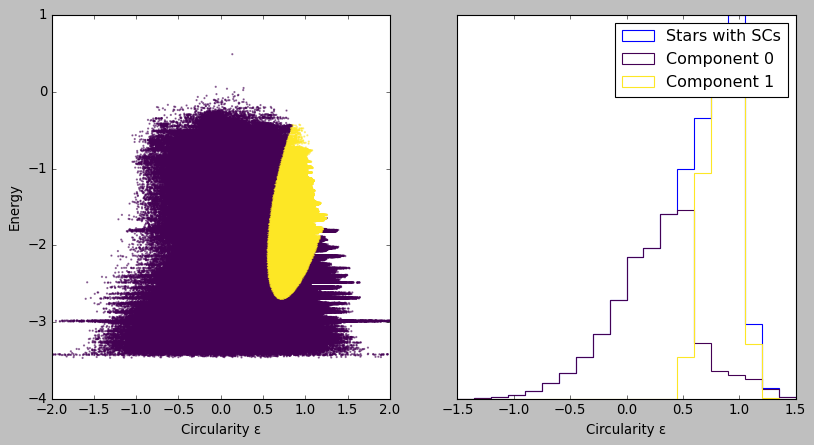

Maximum initial number of clusters per star 7
Maximum initial mass 7.58e+07 Msun
Maximum present-day mass 4.22e+07 Msun
Problematic stars with clusters 13611
That`s 9.420 per cent of stars with clusters


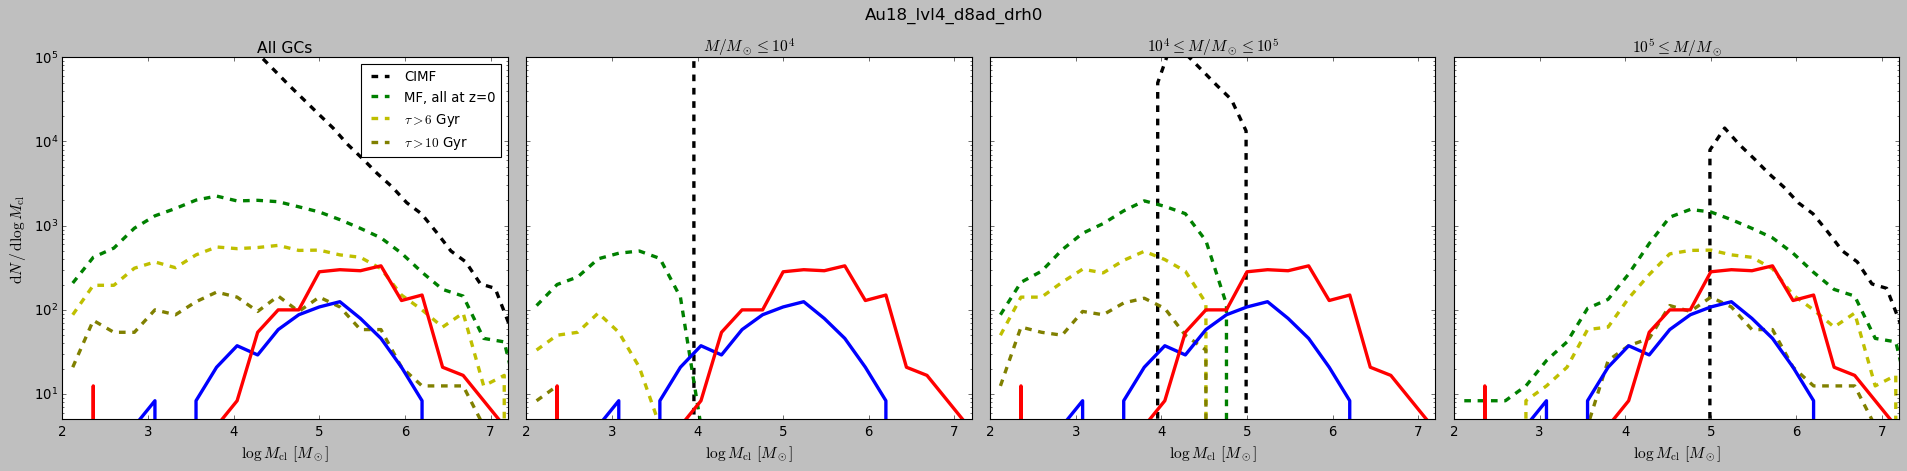

In [11]:
for sim in simulation_list:
    init_full_mass, all_full_mass, young_full_mass, intermediate_full_mass, old_full_mass = get_mass_functions(sim, \
                                                                                                        snapshot=127, subdir='/output/', age_young=1., age_intermediate=6.,\
                                                                                                        age_old=10., low_mass_cut=None, high_mass_cut=None, apply_df=False,\
                                                                                                        decomposition='Spheroid', plot_agedistribution=False, plot_decomposition=True)
    init_low_mass, all_low_mass, young_low_mass, intermediate_low_mass, old_low_mass = get_mass_functions(sim, \
                                                                                                        snapshot=127, subdir='/output/', age_young=1., age_intermediate=6.,\
                                                                                                        age_old=10., low_mass_cut=None, high_mass_cut=1e4, apply_df=False,\
                                                                                                        decomposition='Spheroid', plot_agedistribution=False, plot_decomposition=True)
    init_intermediate_mass, all_intermediate_mass, young_intermediate_mass, intermediate_intermediate_mass, old_intermediate_mass = get_mass_functions(sim, \
                                                                                                        snapshot=127, subdir='/output/', age_young=1., age_intermediate=6.,\
                                                                                                        age_old=10., low_mass_cut=1e4, high_mass_cut=1e5, apply_df=False,\
                                                                                                        decomposition='Spheroid', plot_agedistribution=False, plot_decomposition=True)
    init_high_mass, all_high_mass, young_high_mass, intermediate_high_mass, old_high_mass = get_mass_functions(sim, \
                                                                                                        snapshot=127, subdir='/output/', age_young=1., age_intermediate=6.,\
                                                                                                        age_old=10., low_mass_cut=1e5, high_mass_cut=None, apply_df=False,\
                                                                                                        decomposition='Spheroid', plot_agedistribution=False, plot_decomposition=True)

    fig, ax = plt.subplots(1,4, figsize=(24,6), sharey=True)

    ax[0].plot(imarray_plot, init_full_mass, c='k', linestyle='dashed', linewidth = 3, label='CIMF')
    ax[0].plot(marray_plot, all_full_mass, c='g', linestyle='dashed', linewidth = 3, label=r'MF, all at z=0')
    ax[0].plot(marray_plot, intermediate_full_mass, c='y', linestyle='dashed', linewidth = 3, label=r'$\tau > 6$ Gyr')
    ax[0].plot(marray_plot, old_full_mass, c='olive', linestyle='dashed', linewidth = 3, label=r'$\tau > 10$ Gyr')
    ax[0].set_title('All GCs', fontsize=14)


    ax[1].plot(imarray_plot, init_low_mass, c='k', linestyle='dashed', linewidth = 3, label='CIMF')
    ax[1].plot(marray_plot, all_low_mass, c='g', linestyle='dashed', linewidth = 3, label=r'MF, all at z=0')
    ax[1].plot(marray_plot, intermediate_low_mass, c='y', linestyle='dashed', linewidth = 3, label=r'$\tau > 6$ Gyr')
    ax[1].plot(marray_plot, old_low_mass, c='olive', linestyle='dashed', linewidth = 3, label=r'$\tau > 10$ Gyr')
    ax[1].set_title(r'$M/M_\odot \leq 10^4$', fontsize=14)

    ax[2].plot(imarray_plot, init_intermediate_mass, c='k', linestyle='dashed', linewidth = 3, label='CIMF')
    ax[2].plot(marray_plot, all_intermediate_mass, c='g', linestyle='dashed', linewidth = 3, label=r'MF, all at z=0')
    ax[2].plot(marray_plot, intermediate_intermediate_mass, c='y', linestyle='dashed', linewidth = 3, label=r'$\tau > 6$ Gyr')
    ax[2].plot(marray_plot, old_intermediate_mass, c='olive', linestyle='dashed', linewidth = 3, label=r'$\tau > 10$ Gyr')
    ax[2].set_title(r'$10^4 \leq M/M_\odot \leq 10^5$', fontsize=14)

    ax[3].plot(imarray_plot, init_high_mass, c='k', linestyle='dashed', linewidth = 3, label='CIMF')
    ax[3].plot(marray_plot, all_high_mass, c='g', linestyle='dashed', linewidth = 3, label=r'MF, all at z=0')
    ax[3].plot(marray_plot, intermediate_high_mass, c='y', linestyle='dashed', linewidth = 3, label=r'$\tau > 6$ Gyr')
    ax[3].plot(marray_plot, old_high_mass, c='olive', linestyle='dashed', linewidth = 3, label=r'$\tau > 10$ Gyr')
    ax[3].set_title(r'$10^5 \leq M/M_\odot$', fontsize=14)

    ax[0].set(ylim=(5e0,1e5), yscale= 'log')
    ax[0].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=14)
    ax[0].legend(loc='upper right', fontsize=12)

    for i in range(4):
        ax[i].plot(marray_plot, mw_mass_function, linewidth=3, c='b', label='MW')
        ax[i].plot(marray_plot, m31_mass_function, linewidth=3, c='r', label='M31')
        ax[i].set_xlim(2,7.2)
        ax[i].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=14)
        ax[i].tick_params(labelsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle(sim, fontsize=15)
    # plt.savefig('plots/f1_2_shboost_gcmf_radialbins.pdf')

/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.02146396636962891
Found 1406988 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
GC decomposition label: 0


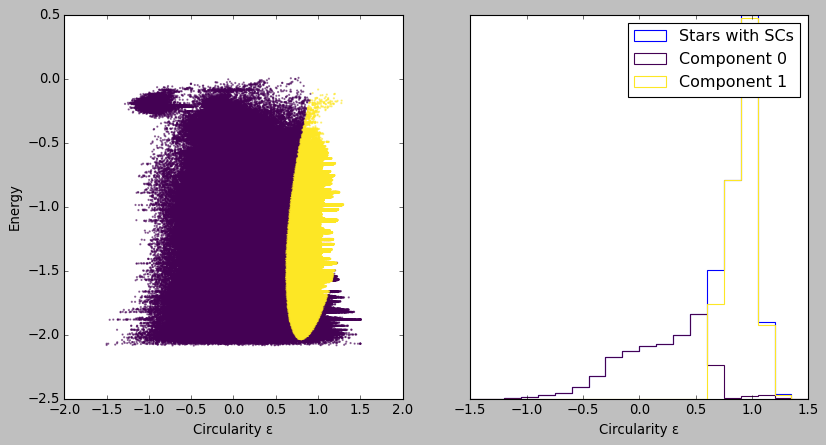

Maximum initial number of clusters per star 5
Maximum initial mass 8.92e+07 Msun
Maximum present-day mass 2.15e+07 Msun
Problematic stars with clusters 3547
That`s 9.746 per cent of stars with clusters


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.02146396636962891
Found 1406988 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
GC decomposition label: 0


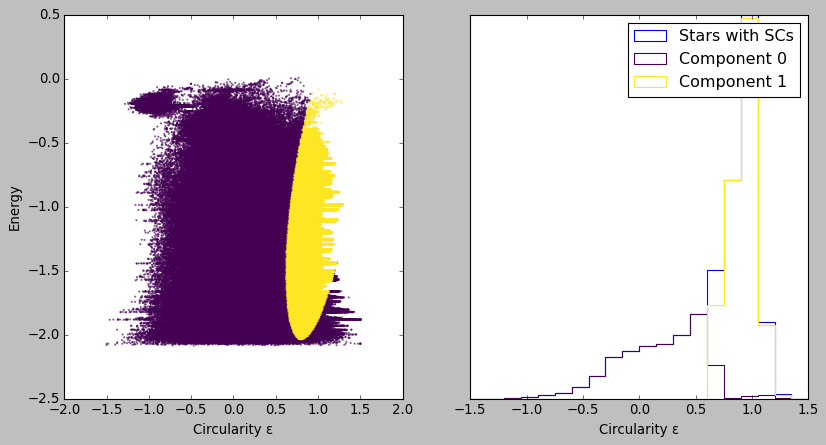

Maximum initial number of clusters per star 5
Maximum initial mass 8.92e+07 Msun
Maximum present-day mass 2.83e+06 Msun
Problematic stars with clusters 2430
That`s 10.136 per cent of stars with clusters


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.02146396636962891
Found 1406988 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
GC decomposition label: 0


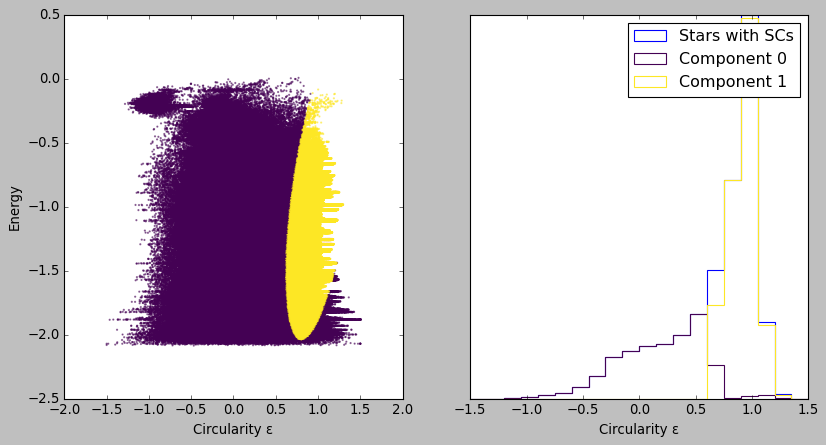

Maximum initial number of clusters per star 5
Maximum initial mass 3.98e+07 Msun
Maximum present-day mass 2.15e+07 Msun
Problematic stars with clusters  544
That`s 9.471 per cent of stars with clusters


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.02146396636962891
Found 1406988 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
GC decomposition label: 0


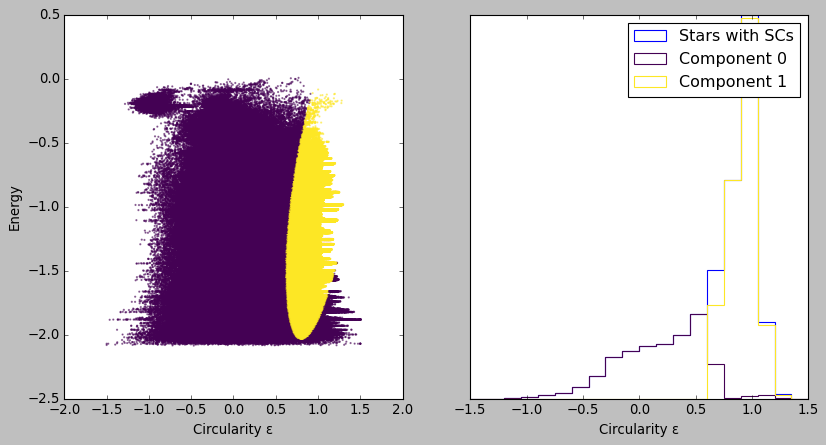

Maximum initial number of clusters per star 5
Maximum initial mass 1.83e+07 Msun
Maximum present-day mass 9.98e+06 Msun
Problematic stars with clusters  573
That`s 8.571 per cent of stars with clusters


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.022342459857463838
Found 2229646 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
GC decomposition label: 0


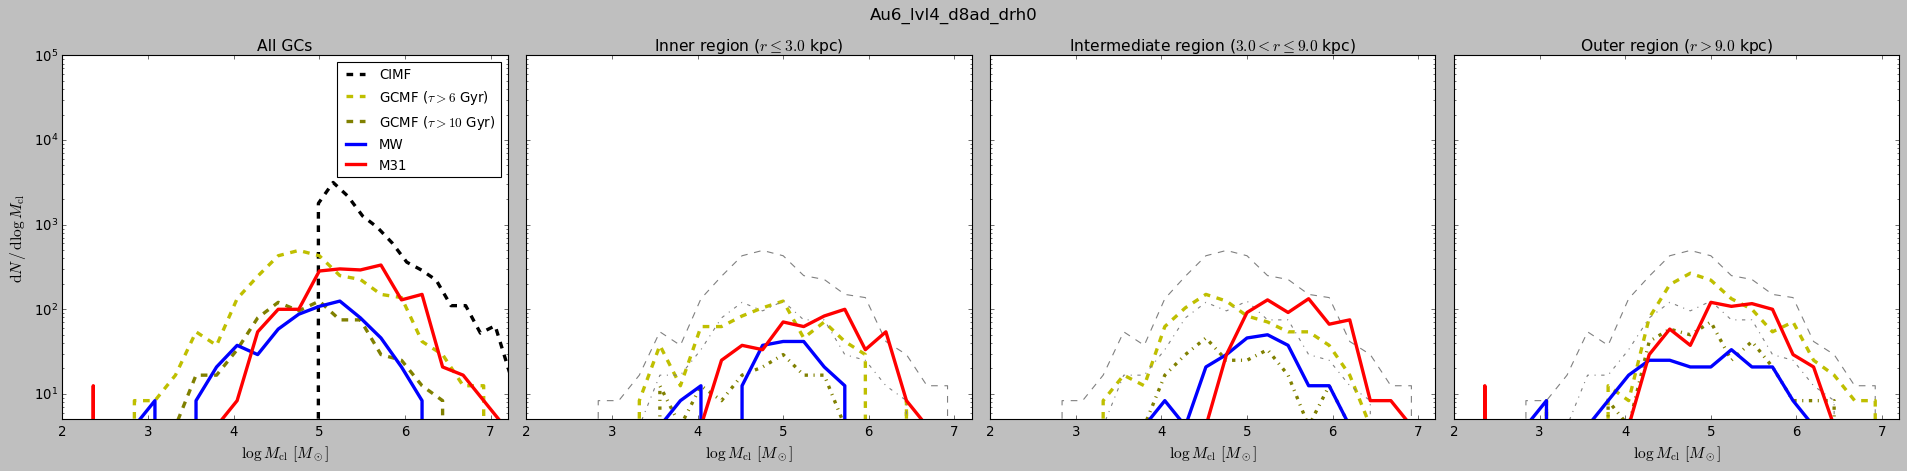

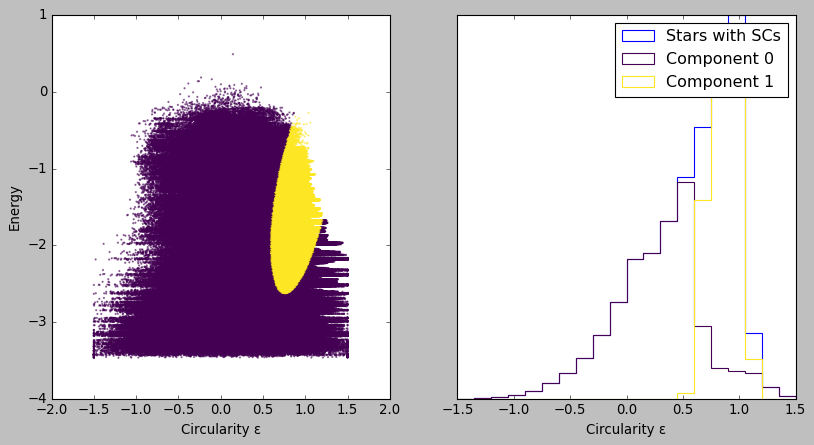

Maximum initial number of clusters per star 7
Maximum initial mass 7.58e+07 Msun
Maximum present-day mass 4.22e+07 Msun
Problematic stars with clusters 14276
That`s 9.416 per cent of stars with clusters


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.022342459857463838
Found 2229646 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
GC decomposition label: 0


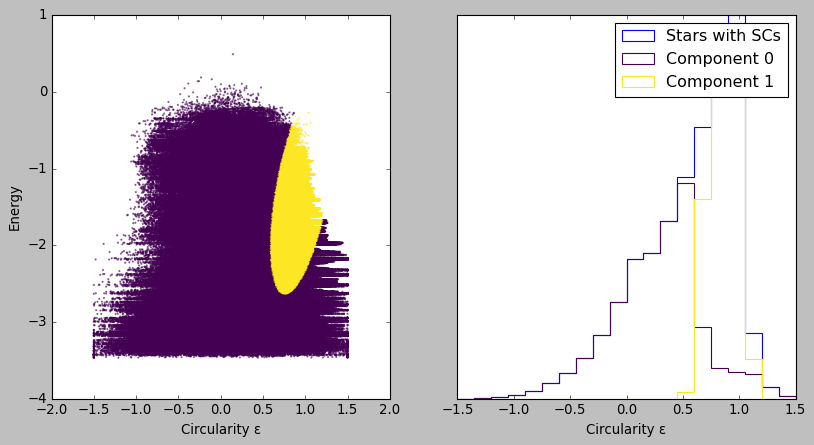

Maximum initial number of clusters per star 7
Maximum initial mass 6.77e+07 Msun
Maximum present-day mass 3.70e+07 Msun
Problematic stars with clusters 11222
That`s 9.613 per cent of stars with clusters


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.022342459857463838
Found 2229646 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
GC decomposition label: 0


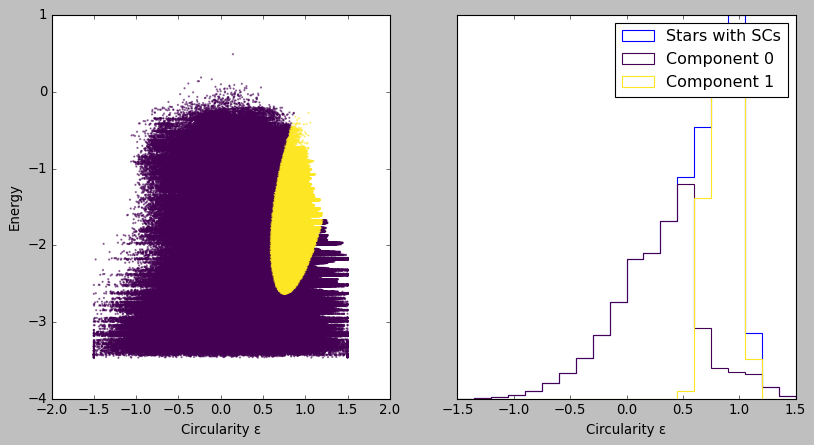

Maximum initial number of clusters per star 7
Maximum initial mass 6.18e+07 Msun
Maximum present-day mass 3.34e+07 Msun
Problematic stars with clusters 2348
That`s 8.847 per cent of stars with clusters


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.022342459857463838
Found 2229646 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
GC decomposition label: 0


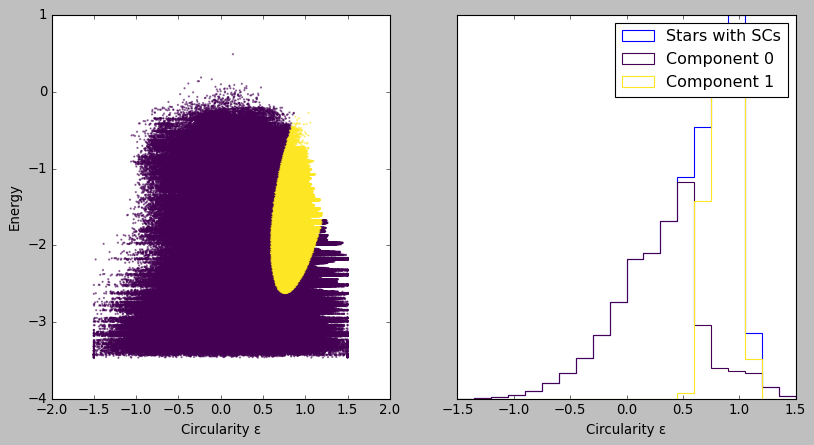

Maximum initial number of clusters per star 7
Maximum initial mass 7.58e+07 Msun
Maximum present-day mass 4.22e+07 Msun
Problematic stars with clusters  676
That`s 8.538 per cent of stars with clusters


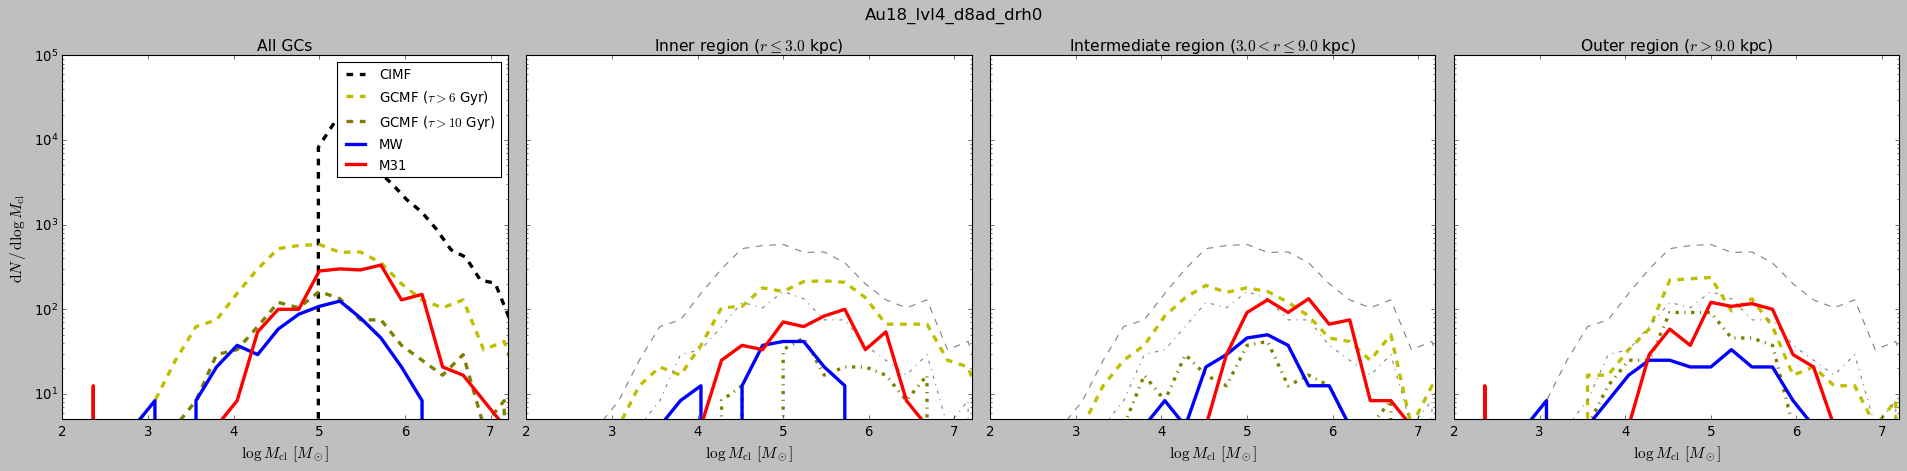

In [17]:
for sim in simulation_list:
    all_init, all_full, all_young, all_intermediate, all_old = get_mass_functions(sim, snapshot=127, age_intermediate=6., age_old=10., apply_df=False,
                                                                                       decomposition='Spheroid', low_mass_cut=1e5, high_mass_cut=None, plot_decomposition=True)
    inner_init, inner_full, inner_young, inner_intermediate, inner_old = get_mass_functions(sim, snapshot=127, outer_radius=3., age_intermediate=6., age_old=10., apply_df=False,
                                                                                       decomposition='Spheroid', low_mass_cut=1e5, high_mass_cut=None, plot_decomposition=True)
    intermediate_init, intermediate_full, intermediate_young, intermediate_intermediate, intermediate_old = get_mass_functions(sim, snapshot=127, inner_radius=3., outer_radius=9., age_intermediate=6., age_old=10., apply_df=False,
                                                                                       decomposition='Spheroid', low_mass_cut=1e5, high_mass_cut=None, plot_decomposition=True)
    outer_init, outer_full, outer_young, outer_intermediate, outer_old = get_mass_functions(sim, snapshot=127, inner_radius=9., age_intermediate=6., age_old=10., apply_df=False,
                                                                                       decomposition='Spheroid', low_mass_cut=1e5, high_mass_cut=None, plot_decomposition=True)

    fig, ax = plt.subplots(1,4, figsize=(24,6), sharey=True)

    ax[0].plot(imarray_plot, all_init, c='k', linestyle='dashed', linewidth = 3, label='CIMF')
    # ax[0].plot(marray_plot, all_full, c='g', linestyle='dashed', linewidth = 3, label='GCMF (all at z=0)')
    ax[0].plot(marray_plot, all_intermediate, c='y', linestyle='dashed', linewidth = 3, label=r'GCMF ($\tau > 6$ Gyr)')
    ax[0].plot(marray_plot, all_old, c='olive', linestyle='dashed', linewidth = 3, label=r'GCMF ($\tau > 10$ Gyr)')
    ax[0].plot(marray_plot, mw_mass_function, linewidth=3, c='b', label='MW')
    ax[0].plot(marray_plot, m31_mass_function, linewidth=3, c='r', label='M31')
    ax[0].set_title('All GCs', fontsize=14)
    ax[0].set_xlim(2,7.2)
    ax[0].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=14)
    ax[0].tick_params(labelsize=12)

    # ax[1].plot(marray_plot, inner_init, c='k', linestyle='dashed', linewidth = 3, label='CIMF')
    # ax[1].plot(marray_plot, inner_full, c='g', linestyle='dashed', linewidth = 3, label='GCMF (all at z=0)')
    ax[1].plot(marray_plot, all_intermediate, c='gray', linestyle='dashed', linewidth = 1, label=r'GCMF ($\tau > 6$ Gyr)')
    ax[1].plot(marray_plot, inner_intermediate, c='y', linestyle='dashed', linewidth = 3, label=r'GCMF ($\tau > 6$ Gyr)')
    ax[1].plot(marray_plot, all_old, c='gray', linestyle='dashdot', linewidth = 1, label=r'GCMF ($\tau > 10$ Gyr)')
    ax[1].plot(marray_plot, inner_old, c='olive', linestyle='dashdot', linewidth = 3, label=r'GCMF ($\tau > 10$ Gyr)')
    ax[1].plot(marray_plot, mw_inner_mass_function, linewidth=3, c='b', label='MW')
    ax[1].plot(marray_plot, m31_inner_mass_function, linewidth=3, c='r', label='M31')
    ax[1].set_title(r'Inner region ($r \leq 3.0$ kpc)', fontsize=14)
    ax[1].set_xlim(2,7.2)
    ax[1].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=14)
    ax[1].tick_params(labelsize=12)

    # ax[2].plot(marray_plot, intermediate_init, c='k', linestyle='dashed', linewidth = 3, label='CIMF')
    # ax[2].plot(marray_plot, intermediate_full, c='g', linestyle='dashed', linewidth = 3, label='GCMF (all at z=0)')
    ax[2].plot(marray_plot, all_intermediate, c='gray', linestyle='dashed', linewidth = 1, label=r'GCMF ($\tau > 6$ Gyr)')
    ax[2].plot(marray_plot, intermediate_intermediate, c='y', linestyle='dashed', linewidth = 3, label=r'GCMF ($\tau > 6$ Gyr)')
    ax[2].plot(marray_plot, all_old, c='gray', linestyle='dashdot', linewidth = 1, label=r'GCMF ($\tau > 10$ Gyr)')
    ax[2].plot(marray_plot, intermediate_old, c='olive', linestyle='dashdot', linewidth = 3, label=r'GCMF ($\tau > 10$ Gyr)')
    ax[2].plot(marray_plot, mw_intermediate_mass_function, linewidth=3, c='b', label='MW')
    ax[2].plot(marray_plot, m31_intermediate_mass_function, linewidth=3, c='r', label='M31')
    ax[2].set_title(r'Intermediate region ($3.0 < r \leq 9.0$ kpc)', fontsize=14)
    ax[2].set_xlim(2,7.2)
    ax[2].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=14)
    ax[2].tick_params(labelsize=12)

    # ax[3].plot(marray_plot, outer_init, c='k', linestyle='dashed', linewidth = 3, label='CIMF')
    # ax[3].plot(marray_plot, outer_full, c='g', linestyle='dashed', linewidth = 3, label='GCMF (all at z=0)')
    ax[3].plot(marray_plot, all_intermediate, c='gray', linestyle='dashed', linewidth = 1, label=r'GCMF ($\tau > 6$ Gyr)')
    ax[3].plot(marray_plot, outer_intermediate, c='y', linestyle='dashed', linewidth = 3, label=r'GCMF ($\tau > 6$ Gyr)')
    ax[3].plot(marray_plot, all_old, c='gray', linestyle='dashdot', linewidth =1, label=r'GCMF ($\tau > 10$ Gyr)')
    ax[3].plot(marray_plot, outer_old, c='olive', linestyle='dashdot', linewidth = 3, label=r'GCMF ($\tau > 10$ Gyr)')
    ax[3].plot(marray_plot, mw_outer_mass_function, linewidth=3, c='b', label='MW')
    ax[3].plot(marray_plot, m31_outer_mass_function, linewidth=3, c='r', label='M31')
    ax[3].set_title(r'Outer region ($r > 9.0$ kpc)', fontsize=14)
    ax[3].set_xlim(2,7.2)
    ax[3].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=14)
    ax[3].tick_params(labelsize=12)


    ax[0].set(ylim=(5e0,1e5), yscale= 'log')
    ax[0].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=14)
    ax[0].legend(loc='upper right', fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle(sim, fontsize=15)
    # plt.savefig('plots/f1_2_shboost_gcmf_radialbins.pdf')

In [6]:
dir = './compare_comp_time/'
simulation_list = [directory for directory in os.listdir(dir) if 'Au6_lvl5' in directory]
print(simulation_list)
simulation_list = [simulation_list[1], simulation_list[9]]
print(simulation_list)

['Au6_lvl5_ec9e_cce_10myr', 'Au6_lvl5_ec9e_10myr', 'Au6_lvl5_814c_tview', 'Au6_lvl5_814c_cce_tview', 'Au6_lvl5_ec9e_fimf_10myr', 'Au6_lvl5_814c_fimf_cce_tview', 'Au6_lvl5_814c_fimf_tview', 'Au6_lvl5_ec9e_fimf_cce_10myr', 'Au6_lvl5_31a28_GG23', 'Au6_lvl5_31a2_eqrhnoevo']
['Au6_lvl5_ec9e_10myr', 'Au6_lvl5_31a2_eqrhnoevo']


In [11]:
initial_population =[]
full_population = []
young_population = []
intermediate_population = []
old_population = []
labels = []

for sim in simulation_list:
    labels.append(sim)
    init, full, young, intermediate, old = get_mass_functions(dir+sim, snapshot=127, apply_df=True, age_young=1., exclude_disk=False)
    initial_population.append(init)
    full_population.append(full)
    young_population.append(young)
    intermediate_population.append(intermediate)
    old_population.append(old)

/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.0197221577167511
Found 70502 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
GC decomposition label: 0
Maximum initial number of clusters per star 11
Maximum initial mass 6.31e+07 Msun
Maximum present-day mass 3.75e+07 Msun
Problematic stars with clusters  248
That`s 1.718 per cent of stars with clusters
Clusters disrupted by dynamical friction    0


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.019447906315326693
Found 85000 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
GC decomposition label: 0
Maximum initial number of clusters per star 13
Maximum initial mass 3.86e+07 Msun
Maximum present-day mass 2.42e+07 Msun
Problematic stars with clusters  141
That`s 1.417 per cent of stars with clusters
Clusters disrupted by dynamical friction    1


/tmp/ipykernel_3352160/1547313509.py:135: RuntimeWarning: divide by zero encountered in divide
  tdf = feps/(2*B(vc_rc_clus/(np.sqrt(2.)*sigma_rc_clus)))*np.sqrt(2.)*sigma_rc_clus*rc_clus**2./(Gcosmo*cluster_masses[not_empty_clusters][init_mass_cut]*coulumblog)
/tmp/ipykernel_3352160/1989140012.py:7: RuntimeWarning: invalid value encountered in multiply
  return sp.special.erf(x) * 2.*x*np.exp(-x**2)/np.sqrt(np.pi)


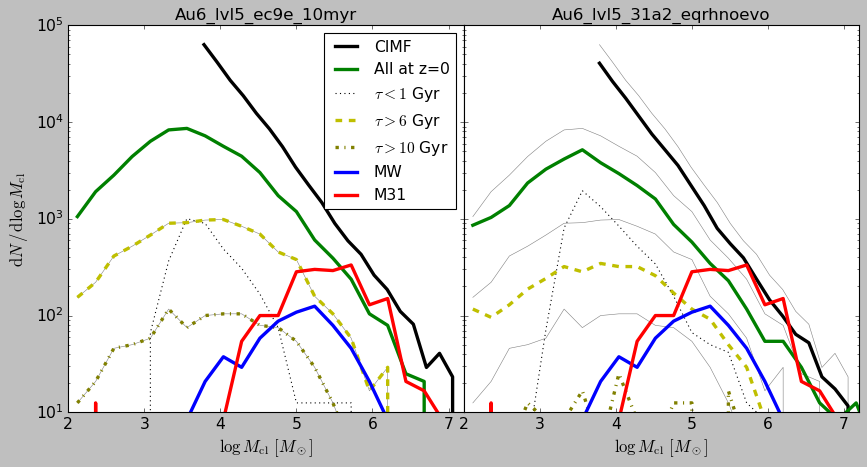

In [12]:
nsubs = 2
fig, ax = plt.subplots(1, nsubs, sharey=True, figsize=(nsubs*5 + 1,6))

for i,mf in enumerate(initial_population):
  # if((i+1)%2 == 0):
  ax[i].plot(imarray_plot, initial_population[0], c='grey', linewidth=0.5)
  ax[i].plot(imarray_plot, mf, c='k', linewidth=3, label='CIMF')

for i,mf in enumerate(full_population):
  # if((i+1)%2 == 0):
  ax[i].plot(marray_plot, full_population[0], c='grey', linewidth=0.5)
  ax[i].plot(marray_plot, mf, c='g', linewidth=3, label='All at z=0')

for i,mf in enumerate(young_population):
  # if((i+1)%2 == 0):
  ax[i].plot(marray_plot, mf, c='k', linewidth=1, linestyle=':', label=r'$\tau < 1$ Gyr')

for i,mf in enumerate(intermediate_population):
  # if((i+1)%2 == 0):
  ax[i].plot(marray_plot, intermediate_population[0], c='grey', linewidth=0.5)
  ax[i].plot(marray_plot, mf, c='y', linewidth=3, linestyle='--', label=r'$\tau > 6$ Gyr')
  
for i,mf in enumerate(old_population):
  # if((i+1)%2 == 0):
  ax[i].plot(marray_plot, old_population[0], c='grey', linewidth=0.5)
  ax[i].plot(marray_plot, mf, c='olive', linewidth=3, linestyle='-.', label=r'$\tau > 10$ Gyr')

for i in range(len(ax)):
  ax[i].plot(marray_plot, mw_mass_function, linewidth=3, c='b', label='MW')
  ax[i].plot(marray_plot, m31_mass_function, linewidth=3, c='r', label='M31')
  ax[i].set_xlim(2,7.2)
  ax[i].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=15)
  ax[i].tick_params(labelsize=14)
  ax[i].set_title(labels[i], fontsize=15)

ax[0].set(ylim=(1e1,1e5), yscale= 'log')
ax[0].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=15)
ax[0].legend(loc='upper right', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(wspace=0)
# plt.savefig('plots/lvl5_10myr_gcmf_compare.pdf')